Checking SNR of accumulated dephasing (detectability criterion from [accretion disk dephasing study](https://arxiv.org/abs/2005.11333)).

In [2]:
%load_ext autoreload
%autoreload 2

# Lots of small/large numbers involved in these calculations, so
# need to use 64-bit mode
from jax.config import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
from jax import random
from corner import corner
from tqdm.auto import tqdm, trange

from binary_jax import *
from analysis_jax import *
from noise import *
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
m_1 = 1e3 * MSUN
m_2 = 1 * MSUN
rho_s = 226 * MSUN / PC**3
gamma_s = 7 / 3
f_l = jnp.array(0.022621092492458004)  # Hz
f_c = get_f_isco(m_1)

vb = make_vacuum_binary(m_1, m_2)
sd = make_static_dress(m_1, m_2, rho_s, gamma_s)
dd = make_dynamic_dress(m_1, m_2, rho_s, gamma_s)

Text(0, 0.5, '$\\Phi_V - \\Phi$ [rad]')

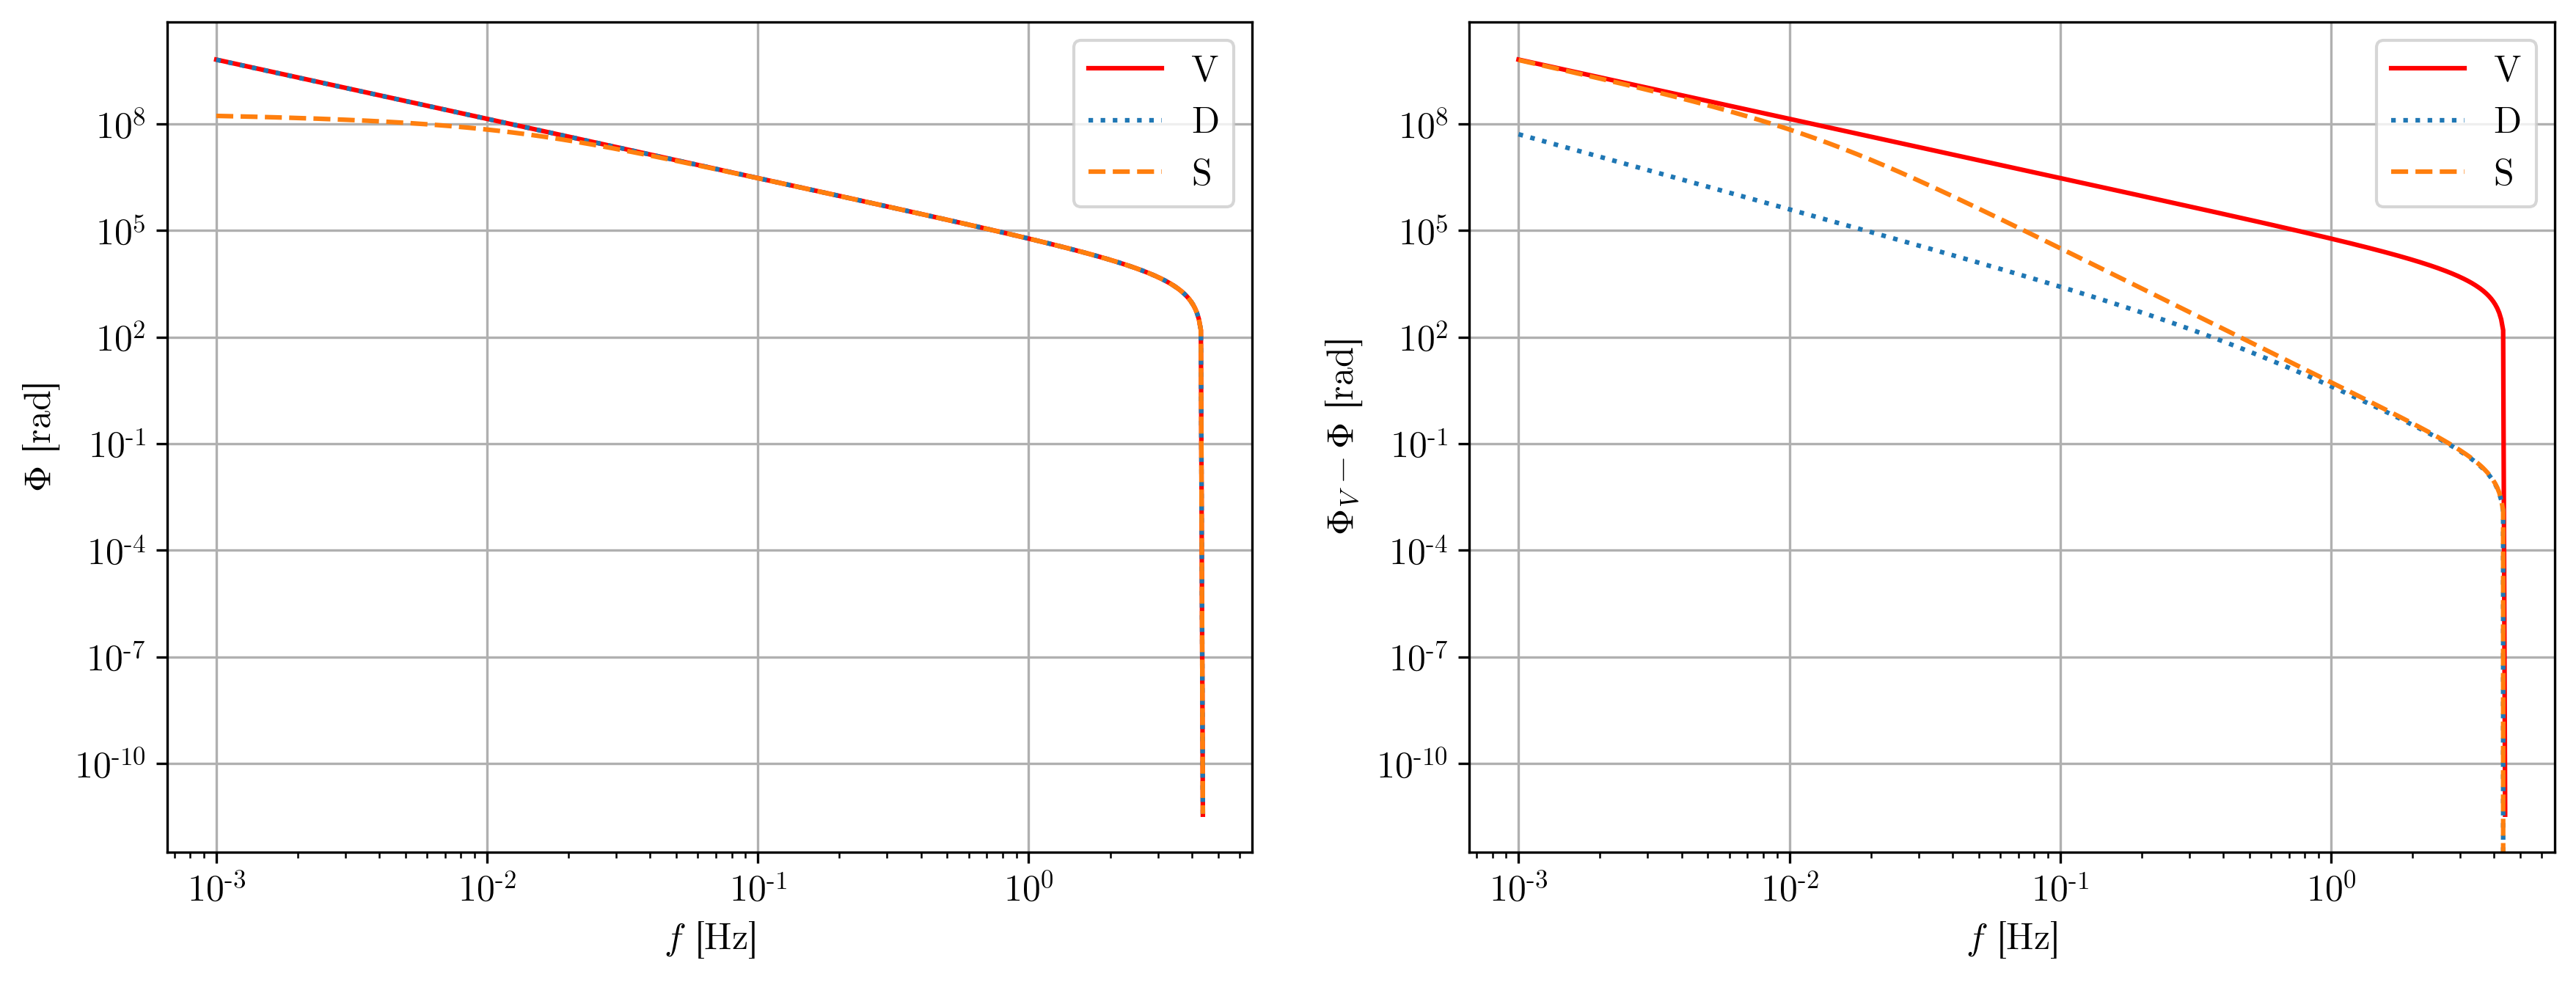

In [4]:
f = jnp.geomspace(1e-3, f_c, 500)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.loglog(f, Phi_to_c(f, f_c, vb, "v"), "r", label="V")
ax.loglog(f, Phi_to_c(f, f_c, dd, "d"), ":", label="D")
ax.loglog(f, Phi_to_c(f, f_c, sd, "s"), "--", label="S")
ax.legend()
ax.grid()
ax.set_xlabel(r"$f$ [Hz]")
ax.set_ylabel(r"$\Phi$ [rad]")

ax = axes[1]
ax.loglog(f, Phi_to_c(f, f_c, vb, "v"), "r", label="V")
ax.loglog(f, Phi_to_c(f, f_c, vb, "v") - Phi_to_c(f, f_c, dd, "d"), ":", label="D")
ax.loglog(f, Phi_to_c(f, f_c, vb, "v") - Phi_to_c(f, f_c, sd, "s"), "--", label="S")
ax.legend()
ax.grid()
ax.set_xlabel(r"$f$ [Hz]")
ax.set_ylabel(r"$\Phi_V - \Phi$ [rad]")

Text(0, 0.5, '$\\Psi_V - \\Psi$ [rad]')

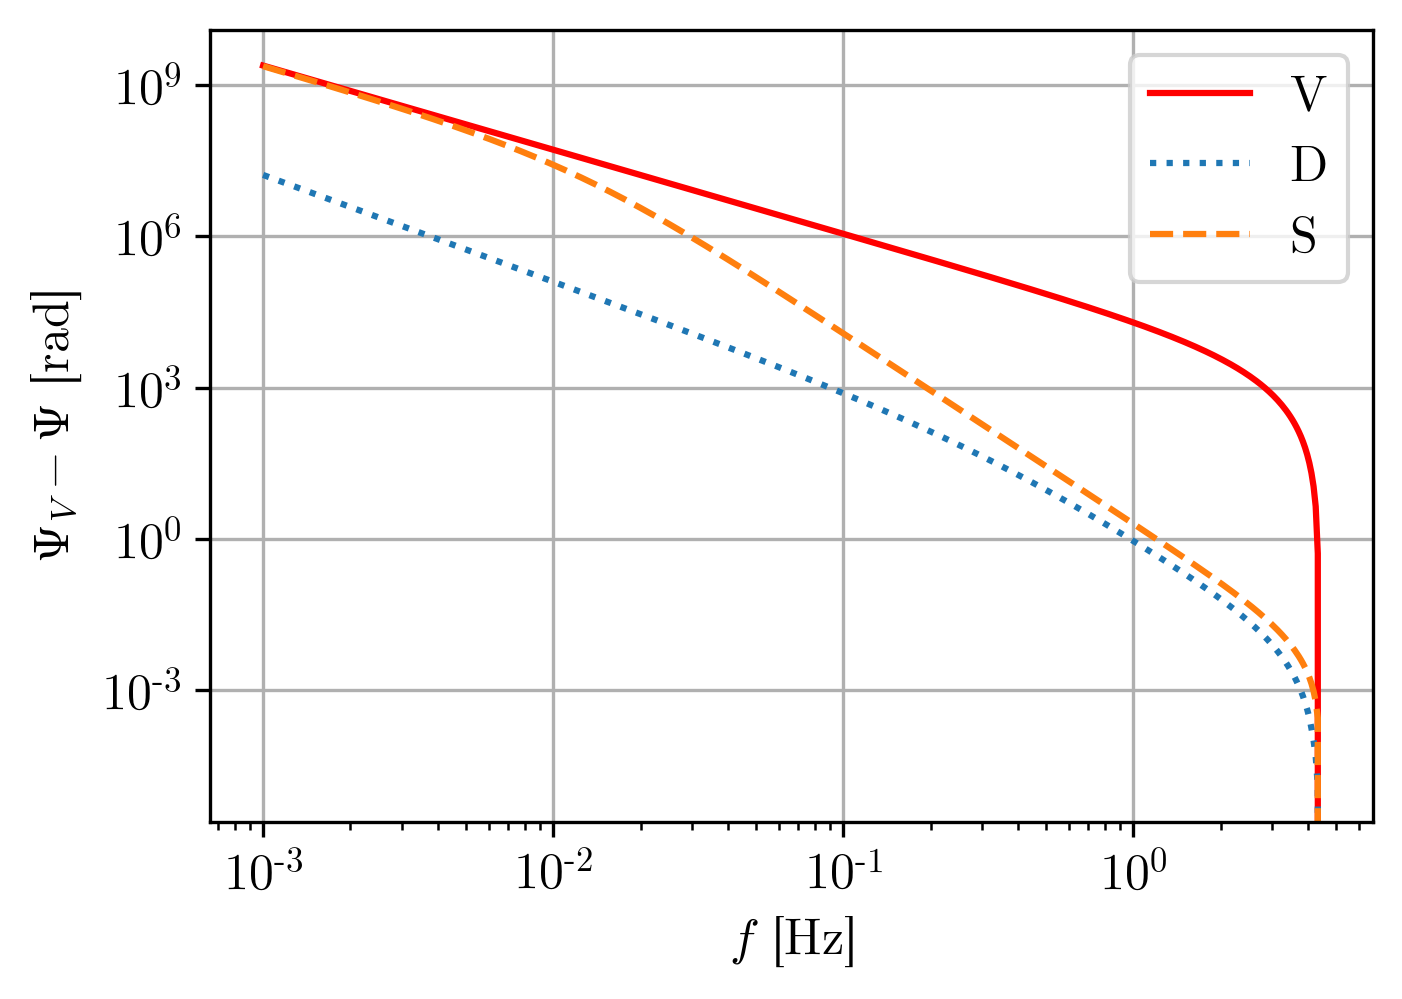

In [5]:
f = jnp.geomspace(1e-3, f_c, 500)
fig, ax = plt.subplots(1, 1)#, figsize=(14, 5))

ax.loglog(f, Psi(f, f_c, vb, "v"), "r", label="V")
ax.loglog(f, Psi(f, f_c, vb, "v") - Psi(f, f_c, dd, "d"), ":", label="D")
ax.loglog(f, Psi(f, f_c, vb, "v") - Psi(f, f_c, sd, "s"), "--", label="S")
ax.legend()
ax.grid()
ax.set_xlabel(r"$f$ [Hz]")
ax.set_ylabel(r"$\Psi_V - \Psi$ [rad]")

Text(0, 0.5, '$\\Phi_V - \\Phi$ (accumulated) [rad]')

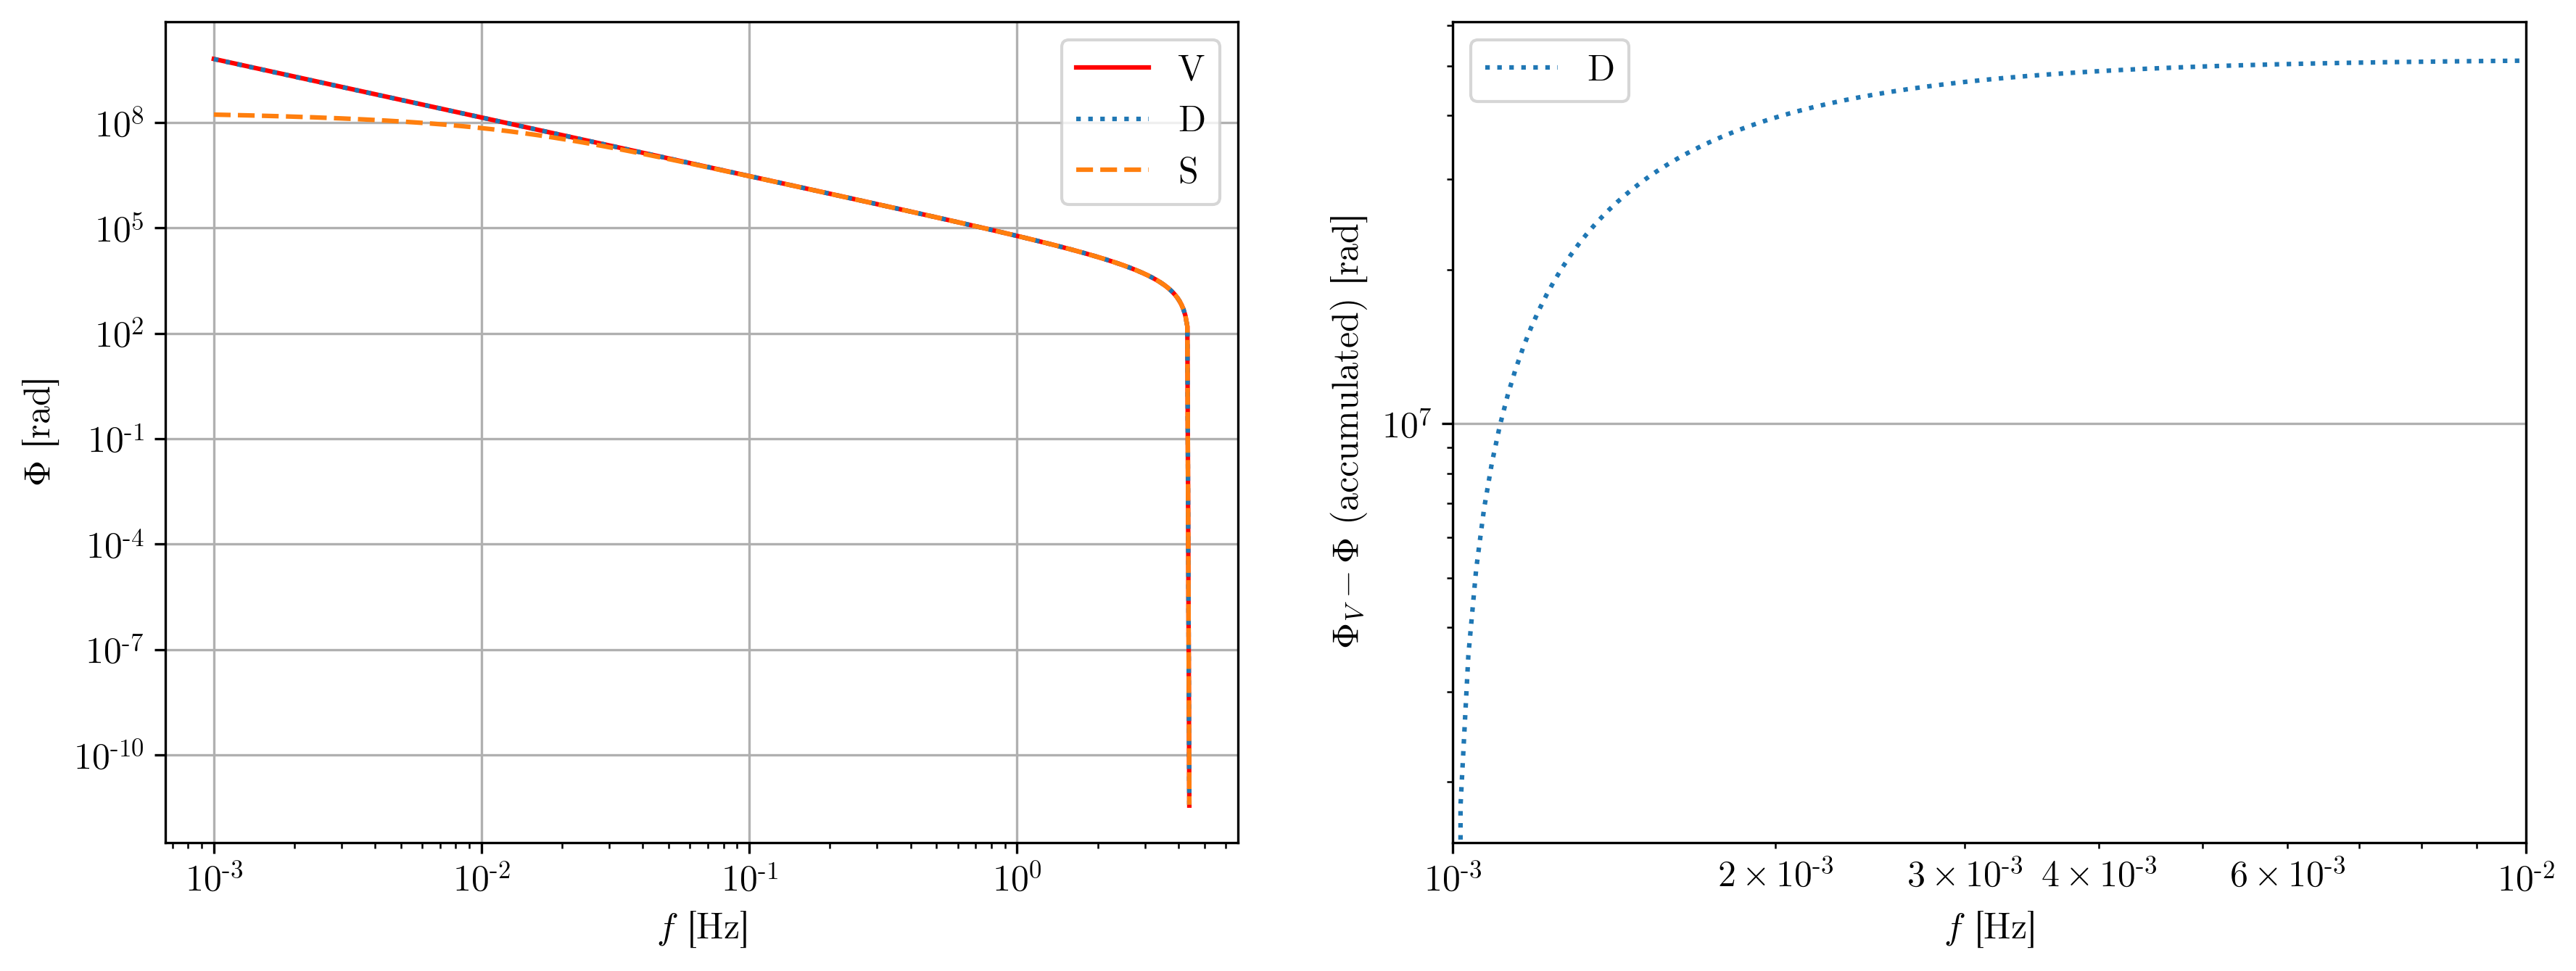

In [15]:
f = jnp.geomspace(1e-3, f_c, 500)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.loglog(f, Phi_to_c(f, f_c, vb, "v"), "r", label="V")
ax.loglog(f, Phi_to_c(f, f_c, dd, "d"), ":", label="D")
ax.loglog(f, Phi_to_c(f, f_c, sd, "s"), "--", label="S")
ax.legend()
ax.grid()
ax.set_xlabel(r"$f$ [Hz]")
ax.set_ylabel(r"$\Phi$ [rad]")

ax = axes[1]
Phi_acc_v = Phi_to_c(f, f_c, vb, "v")[0] - Phi_to_c(f, f_c, vb, "v")
Phi_acc_d = Phi_to_c(f, f_c, dd, "d")[0] - Phi_to_c(f, f_c, dd, "d")
Phi_acc_s = Phi_to_c(f, f_c, sd, "s")[0] - Phi_to_c(f, f_c, sd, "s")
# ax.loglog(f, Phi_acc_v, "r", label="V")
ax.loglog(f, Phi_acc_v - Phi_acc_d, ":", label="D")
# ax.semilogx(f, Phi_acc_v - Phi_acc_s, "--", label="S")
plt.xlim(1e-3, 1e-2)
ax.legend()
ax.grid()
ax.set_xlabel(r"$f$ [Hz]")
ax.set_ylabel(r"$\Phi_V - \Phi$ (accumulated) [rad]")

In [133]:
@jit
def calculate_dephasing_SNR(dd: DynamicDress, vb: VacuumBinary, f_l, f_c):
    integrand = lambda f: 4 * amp_plus(f, vb, "v")**2 * (
        2 * (1 - jnp.cos(Psi(f, f_c, vb, "v") - Psi(f, f_c, dd, "d")))
    ) / S_n_LISA(f)
    return jnp.sqrt(simps(integrand, f_l, f_c, 100000, True))

In [134]:
print("SNR (v-d): ", calculate_dephasing_SNR(dd, vb, f_l, f_c))
print("SNR (d):   ", calculate_SNR(dd, f_c, "d", f_l, f_c, 30000))
print("SNR (v):   ", calculate_SNR(vb, f_c, "v", f_l, f_c, 30000))

SNR (v-d):  13.015637192011582
SNR (d):    9.193760960108461
SNR (v):    9.203580893239108


Clearly we can just drop the `cos(Delta Psi)` term, so I'm not sure this tells us much.